# Load Experiments as metrics

In [ ]:
# calculate metrics
# script to final metrics

import glob
import os
import numpy as np

os.chdir('/home.dokt/vacekpa2/let-it-flow')
import pandas as pd

from vis.render import vis_data
from vis.deprecated_vis import *
exps = sorted(glob.glob('/datagrid/public_datasets/let-id-flow/experiments/mb_argoverse/*'))

for exp in exps:
    # print(exp)
    if len(os.path.basename(exp)) == 1:
        cfg = pd.read_csv(os.path.join(exp, 'config.csv'), index_col=0).iloc[0].to_dict()
        print(cfg)

    try:
        threeway_epe = [pd.read_csv(os.path.join(exp, f'{file}.csv'), index_col=0).to_dict()['0']['EPE'] for file in ['DFG', 'SFG', 'SBG']]
        # metrics = pd.read_csv(os.path.join(exp, 'overall.csv'), index_col=0).to_dict()['0']
        
        print({'DFG' : f"{threeway_epe[0]:.3f}", 'SFG' : f"{threeway_epe[1]:.3f}", 'SBG' :  f"{threeway_epe[2]:.3f}", 'average' : f"{(threeway_epe[0] + threeway_epe[1] + threeway_epe[2])/3:.3f}"}, end=' ')
        overall_epe = pd.read_csv(os.path.join(exp, 'overall.csv'), index_col=0).to_dict()['0']['EPE']
        print(f"overall : {overall_epe:.3f}")
    except:
        print(exp, ' with no metric')

    inference = sorted(glob.glob(exp + '/inference/*.npz'))
    

    
    # for idx, inference_file in enumerate(inference):

        
    #     inf_file = np.load(inference_file, allow_pickle=True)
    #     pc1 = inf_file['pc1']
    #     pc2 = inf_file['pc2']
    #     gt_flow = inf_file['gt_flow']
    #     pred_flow = inf_file['pred_flow']

    #     data_dict = {'pts': pc1, 'pc2': pc2, 'gt_flow': gt_flow, 'pred_flow': pred_flow, 'id_mask' : np.zeros(pc1.shape[0])}
        # vis_data(data_dict=data_dict, path=os.path.basename(inference_file))
        # break
        # if idx == 30: break

    # break


# Mechanism Visualization

### Polar KNN

In [1]:

import os
os.chdir('/home.dokt/vacekpa2/let-it-flow')
import sys
import time
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from data.PATHS import EXP_PATH

from pytorch3d.ops.knn import knn_points

from models.NP import NeuralPriorNetwork
from models.scoopy.get_model import PretrainedSCOOP

from loss.flow import GeneralLoss

from ops.metric import SceneFlowMetric
from data.dataloader import NSF_dataset

from configs.evalute_datasets import cfg as cfg_df
from models.seed import seed_everything
from vis.deprecated_vis import *
# from vis.render import vis_data
# !pip install torch_scatter

cfg = {'dataset_type': 'waymo',
                    'model' : 'NP',
                    'lr': 0.008,
                    'K': 4,    
                    'max_radius': 2,
                    'grid_factor': 10,
                    'smooth_weight': 1,
                    'forward_weight': 1,
                    'sm_normals_K': 4,                
                    'early_patience': 0,
                    'max_iters': 400,
                    'runs': 1,
                    
                    }

from sklearn.cluster import DBSCAN
from loss.flow import GeneralLoss
from loss.instance import DensityLoss
from loss.flow import SC2_KNN

from tqdm import tqdm
from loss.instance import DensityLoss, smooth_cluster_ids
from loss.flow import GeneralLoss
from ops.visibility2D import calculate_polar_coords
from models.let_it_flow import generate_polar_KNN

if torch.cuda.is_available():
        device = torch.device(7)
else:
    device = torch.device('cpu')

# DBLoss = DensityLoss(pc, eps=0.15, min_samples=1)
# visualize_multiple_pcls(*[pc[i].detach().cpu().numpy() for i in range(len(pc))]

if __name__ == '__main__':

    if torch.cuda.is_available():
        device = torch.device(7)
    else:
        device = torch.device('cpu')

    for run in range(cfg['runs']):

        metric = SceneFlowMetric()
        dataset = NSF_dataset(dataset_type=cfg['dataset_type'])

        

        for f, data in enumerate(tqdm(dataset)):
            if f != 10: continue    # 61 end

            max_loss = 100000
            pc1 = data['pc1'].to(device)
            pc2 = data['pc2'].to(device)
            gt_flow = data['gt_flow'].to(device)

            M = 75
            # SmoothLosses = GeneralLoss(pc1=pc1[:, :, :3], pc2=pc1[:, :, :3], K=16, smooth_weight=1)
            # DBLoss = DensityLoss(pc1, eps=0.15, min_samples=1)

            logs_mask = torch.rand(pc1.shape[0], pc1.shape[1], M, device=device, requires_grad=True)
            optimizer = torch.optim.Adam([logs_mask], lr=0.003)

            # apply DBSCAN to pc1 with eps 0.8 and min_samples=30 in the following lines
            clusters = DBSCAN(eps=0.8, min_samples=30).fit(pc1[0].detach().cpu().numpy()).labels_
            


            break

c_id = 25

from models.let_it_flow import generate_polar_KNN

nn_ind = generate_polar_KNN(pc1, K=9, max_depth_diff=0.5)
visualize_KNN_connections(pc1[0].detach().cpu().numpy(), nn_ind[0, :].detach().cpu().numpy())

  5%|███                                                           | 10/202 [00:03<01:14,  2.59it/s]


# Qualitative Examples

### Flow and Clusters

In [13]:
# probabilities in spectral clustering
from loss.flow import SC2_KNN, GeneralLoss, MBSC
from loss import sc_utils
from tqdm import tqdm

p1 = pc1[0, clusters==c_id].unsqueeze(0)
p2 = pc2
f1 = torch.zeros(p1.shape[0], p1.shape[1], 3, requires_grad=True, device=device)
# mask = torch.rand(p1.shape[0], p1.shape[1], 10, requires_grad=True, device=device)

optimizer = torch.optim.Adam([f1], lr=0.01)

d_thre = 0.03 * 2

SC2_Loss = SC2_KNN(pc1=p1, K=16, use_normals=False, d_thre=d_thre)
SmoothLoss = GeneralLoss(p1, p2, K=8, smooth_weight=1, forward_weight=1, use_normals=False)

# visualize_points3D(p1[0].detach().cpu().numpy(), mask[0].argmax(dim=-1).detach().cpu().numpy())
# d_thre = 0.03 / 10000

for i in tqdm(range(500)):
    optimizer.zero_grad()
    
    loss = 0
    dist, _, _ = knn_points(p1 + f1, p2)
    # backward_dist, _, _ = knn_points(p2, p1 + f1)
    loss += 3 * dist.mean() #+ backward_dist[backward_dist < 1.].mean() #+ SC2_Loss(f1).mean()
    # smooth_loss, per_point_smooth = SmoothLoss.smoothness_loss(mask.softmax(dim=-1), SmoothLoss.NN_pc1)
    # loss += smooth_loss
    # src_keypts = torch.cat((p1, mask.softmax(dim=-1)), dim=-1).detach()    
    # SC2_Loss.src_keypts = src_keypts[:, SC2_Loss.kNN[:, :, :]]

    # target_keypts = torch.cat((f1, mask.softmax(dim=-1)), dim=-1)
    target_keypts = f1
    loss += SC2_Loss(target_keypts).mean()
    
    if i % 100 == 0: print(loss.item())
    loss.backward()
    optimizer.step()


visualize_flow3d(p1[0], p2[0], f1[0])
# visualize_points3D(p1[0].detach().cpu().numpy(), mask[0].argmax(dim=-1).detach().cpu().numpy())
# visualize_flow3d(p1[0], p2[0], gt_flow[0, clusters==c_id, :3])

  2%|█▎                                                            | 11/500 [00:00<00:09, 49.13it/s]

0.023509178310632706


 22%|█████████████▏                                               | 108/500 [00:02<00:07, 51.79it/s]

0.010048627853393555


 42%|█████████████████████████▌                                   | 210/500 [00:04<00:05, 51.52it/s]

0.010022266767919064


 61%|█████████████████████████████████████▎                       | 306/500 [00:05<00:03, 52.23it/s]

0.01002712082117796


 82%|█████████████████████████████████████████████████▊           | 408/500 [00:07<00:01, 51.55it/s]

0.010032369755208492


100%|█████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 51.71it/s]


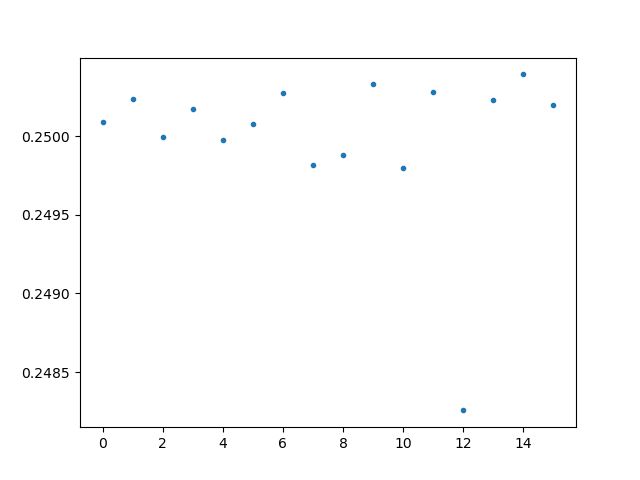

0.24825607


In [22]:

from ops.rays import raycast_NN

_, spring_knn, _ = knn_points(p1, p1, K=16)
r_, ind_ = raycast_NN(pc1[0, clusters==c_id].detach().cpu().numpy(), spring_knn[0].detach().cpu().numpy(), fill_pts=10)

spring_energy = SC2_Loss.leading_eig.view(-1).detach().cpu().numpy()
r_.shape, spring_energy.shape
# visualize_points3D(r_, ind_[:,1], lookat=[0,0,0])

plt.plot(SC2_Loss.leading_eig[471].view(-1).detach().cpu().numpy(), '.')

imshow(plt)
plt.close()
print(SC2_Loss.leading_eig[471].view(-1).detach().cpu().numpy()[-4])
l, u = torch.linalg.eigh(SC2_Loss.A[471])
SC2_Loss.kNN[0,471, -4]

# visu
# torch.abs(u[-, -1])
visualize_flow3d(p1[0], p2[0], f1[0])
# visualize_points3D(p1[0], torch.range(0, p1.shape[1]-1), lookat=[0,0,0])
# visualize_flow3d(p1[0], p2[0], gt_flow[0, clusters==c_id, :3])

In [ ]:
from loss import sc_utils

p1 = pc1[0, clusters==c_id].unsqueeze(0)
p2 = pc2
f_mb = torch.zeros(p1.shape[0], p1.shape[1], 3, requires_grad=True, device=device)

optimizer = torch.optim.Adam([f_mb], lr=0.001)


def MBSC_loss(p1, f1):
    
    pc1_deformed = p1 + f1
    cluster_cs_loss = sc_utils.spatial_consistency_loss(p1, pc1_deformed,
                                                d_thre=0.03)
    loss_sc = cluster_cs_loss
    loss_sc = loss_sc.squeeze()
    loss_sc = 1 * loss_sc

    return loss_sc


for i in range(1000):
    optimizer.zero_grad()
    dist, _, _ = knn_points(p1 + f_mb, p2)
    
    # loss = dist.mean() + SC2_Loss(f_mb).mean()
    loss = dist.mean() + MBSC_loss(p1, f_mb).mean()
    loss.backward()
    optimizer.step()
    # print(loss.item())

# visualize_flow3d(p1[0], p2[0], f1[0])

In [ ]:
from vis.utils import flow_to_rgb
# max_flow_radius = max(f1[0].detach().cpu().numpy().max(), f_mb[0].detach().cpu().numpy().max(), gt_flow[0, clusters==c_id, :3].detach().cpu().numpy().max())
max_flow_radius = None


flow_KNN = flow_to_rgb(f1[0].detach().cpu().numpy(), flow_max_radius=max_flow_radius, background='bright') / 255.
# flow_MB = flow_to_rgb(f_mb[0].detach().cpu().numpy(), flow_max_radius=max_flow_radius, background='bright') / 255.
gt_flow_vis = flow_to_rgb(gt_flow[0, clusters==c_id, :3].detach().cpu().numpy(), flow_max_radius=max_flow_radius, background='bright') / 255.


# visualize_flow3d(p1[0], p2[0], f1[0])
# visualize_flow3d(p1[0], p2[0], f_mb[0])

diff_f1 = (f1[0] - gt_flow[0, clusters==c_id, :3]).norm(dim=-1)
# diff_mb = (f_mb[0] - gt_flow[0, clusters==c_id, :3]).norm(dim=-1)
diff_gt = (gt_flow[0, clusters==c_id, :3] - gt_flow[0, clusters==c_id, :3]).norm(dim=-1)

lookat = [-32.735, -8.366, -0.656]
scale = [0, 0.1]
bg_color = (.0, .0, .0, 0.0)
r = 7.2


# visualize_points3D(pc1[0], clusters, bg_color=bg_color, show_grid=False, show_axis=False, lookat=lookat, r=30)

# clustering motion feature vectors
from sklearn.cluster import DBSCAN
eps=0.02    # 0.02 works
min_samples=1
# ours_clusters = DBSCAN(eps=eps, min_samples=min_samples).fit(f1[0].detach().cpu().numpy()).labels_
# mb_clusters = DBSCAN(eps=eps, min_samples=min_samples).fit(f_mb[0].detach().cpu().numpy()).labels_
# gt_clusters = DBSCAN(eps=eps, min_samples=min_samples).fit(gt_flow[0,clusters==c_id, :3].detach().cpu().numpy()).labels_

# visualize_points3D(p1[0], ours_clusters, bg_color=bg_color, show_grid=False, show_axis=False, lookat=lookat, r=r)
# visualize_points3D(p1[0], mb_clusters, bg_color=bg_color, show_grid=False, show_axis=False, lookat=lookat, r=r)
# visualize_points3D(p1[0], gt_clusters, bg_color=bg_color, show_grid=False, show_axis=False, lookat=lookat, r=r)

# visualize_flow3d(pc1[0], pc2[0], gt_flow[0, :, :3])

# visualize_points3D(p1[0], diff_f1, bg_color=bg_color, show_grid=False, show_axis=False, color_map_scale=scale, lookat=lookat, r=r)
# visualize_points3D(p1[0], diff_mb,  bg_color=bg_color, show_grid=False, show_axis=False, color_map_scale=scale, lookat=lookat, r=r)
# visualize_points3D(p1[0], diff_gt,  bg_color=bg_color, show_grid=False, show_axis=False, color_map_scale=scale, lookat=lookat, r=r)
# mb_heading = torch.atan2(f_mb[0, :, 1], f_mb[0, :, 0])
gt_heading = torch.atan2(gt_flow[0, clusters==c_id, 1], gt_flow[0, clusters==c_id, 0])
ours_heading = torch.atan2(f1[0, :, 1], f1[0, :, 0])

f1_mag = f1[0].norm(dim=-1)
# f_mb_mag = f_mb[0].norm(dim=-1)
gt_mag = gt_flow[0, clusters==c_id, :3].norm(dim=-1)

# gt_flow_vis[:, 0] *= 2
# flow_KNN[:, 0] *= 1.5
# flow_MB[:, 0] *= 1.5
visualize_points3D(p1[0], flow_KNN, bg_color=bg_color, show_grid=False, show_axis=False, lookat=lookat, r=r, show_info=False)
# visualize_points3D(p1[0], flow_MB,  bg_color=bg_color, show_grid=False, show_axis=False, lookat=lookat, r=r, show_info=False)
visualize_points3D(p1[0], gt_flow_vis, bg_color=bg_color, show_grid=False, show_axis=False, lookat=lookat, r=r, show_info=False)